In [1]:
import os
import os.path as osp
import re

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import random

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Dataset, Data

/jet/home/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /ocean/projects/eng170006p/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/jet/home/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /ocean/projects/eng170006p/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
"""
This function `read_mesh(filename)` processes a VTK file containing mesh data to extract points, elements, and scalar values.

Steps:
1. **Parse Points**:
   - Reads the coordinates of points from the VTK file.
   - Handles potential duplicate points by removing duplicates and mapping original indices to the new unique points.

2. **Extract Scalar Values (`phi`)**:
   - Reads scalar values (e.g., `phi`) associated with each point from the POINT_DATA section of the VTK file.
   - Averages scalar values if there are duplicate points.

3. **Parse Elements**:
   - Reads elements (cells) and remaps their point indices to match the deduplicated points.

4. **Compute Edges and Attributes**:
   - Identifies edges by connecting nodes within each element.
   - Computes attributes for each edge, such as the Euclidean distance between connected nodes.
   - All edges are included regardless of length.

5. **Return Values**:
   - `unique_points`: Array of deduplicated point coordinates.
   - `deduplicated_phi`: Scalar values associated with the deduplicated points.
   - `elements`: Array of elements with remapped point indices.
   - `edge_attributes`: DataFrame containing edge connections (node pairs) and their computed distances.

Usage:
- Call this function with the path to a VTK file to extract and process the mesh data.
- The returned data can be used for further mesh analysis, visualization, or as input to other computational methods.
"""

def is_point_on_segment(p, q, r, tolerance=1e-6):
    """Check if point r lies on the line segment pq."""
    # Check if r is collinear with p and q
    collinear = np.isclose(np.cross(q - p, r - p), 0, atol=tolerance)
    if not collinear:
        return False
    
    # Check if r is within the bounds of the segment pq
    within_bounds = np.all(r >= np.minimum(p, q)) and np.all(r <= np.maximum(p, q))
    return within_bounds

def grid_hash(points, grid_size=1.0):
    """Hashes points into a spatial grid."""
    grid = defaultdict(list)
    for idx, point in enumerate(points):
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

def get_nearby_points(p, q, grid, points, grid_size=1.0):
    """Returns points in grid cells near the line segment pq."""
    p_grid_key = (int(p[0] // grid_size), int(p[1] // grid_size))
    q_grid_key = (int(q[0] // grid_size), int(q[1] // grid_size))
    
    min_key = (min(p_grid_key[0], q_grid_key[0]), min(p_grid_key[1], q_grid_key[1]))
    max_key = (max(p_grid_key[0], q_grid_key[0]), max(p_grid_key[1], q_grid_key[1]))

    nearby_points = []
    for i in range(min_key[0], max_key[0] + 1):
        for j in range(min_key[1], max_key[1] + 1):
            if (i, j) in grid:
                nearby_points.extend(grid[(i, j)])
    return nearby_points

def split_edge_by_nodes(edge, points, grid, grid_size=1.0):
    """Split an edge if any nodes with odd coordinates lie on it."""
    p, q = edge
    split_points = [p]
    
    nearby_points = get_nearby_points(points[p], points[q], grid, points, grid_size)
    for r in nearby_points:
        if is_point_on_segment(points[p], points[q], points[r]):
            # print(f"Splitting edge {p}-{q} at point {r}")  # Diagnostic print
            split_points.append(r)
    
    split_points.append(q)
    split_points = sorted(set(split_points), key=lambda idx: np.linalg.norm(points[split_points[0]] - points[idx]))
    
    return [(split_points[i], split_points[i + 1]) for i in range(len(split_points) - 1)]

def read_mesh(filename, grid_size=1.0, verbose=1.0):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse points and handle potential duplicates
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points_end = points_start + 1 + num_points

    raw_points = []
    for line in lines[points_start + 1:points_end]:
        x, y, _ = map(float, line.strip().split())
        raw_points.append([x, y])
    raw_points = np.array(raw_points)

    # Remove duplicates from points array and map original indices to new indices
    unique_points, indices = np.unique(raw_points, axis=0, return_inverse=True)

    # Initialize dictionary to store all scalar fields
    scalar_fields = {}

    # Loop through all scalar fields in the VTK file
    i = 0
    while i < len(lines):
        if 'SCALARS' in lines[i]:
            # Extract the scalar field name
            field_name = lines[i].split()[1]
            # Find the lookup table start for this scalar field
            lookup_table_start = i + 2  # SCALARS + 1 line + LOOKUP_TABLE line
            values = []
            for j in range(lookup_table_start, lookup_table_start + num_points):
                values.append(float(lines[j].strip()))
            scalar_fields[field_name] = np.array(values)
            i = lookup_table_start + num_points  # Move index forward to next scalar field
        else:
            i += 1

    # Combine scalar values for duplicated points (e.g., averaging)
    deduplicated_data = {}
    for name, data in scalar_fields.items():
        deduplicated_values = np.zeros(len(unique_points))
        count = np.zeros(len(unique_points))
        for i, idx in enumerate(indices):
            deduplicated_values[idx] += data[i]
            count[idx] += 1
        deduplicated_values /= count  # Average the values for duplicates
        deduplicated_data[name] = deduplicated_values

    # Read elements and remap their point indices to the deduplicated indices
    cells_start = lines.index(next(line for line in lines if 'CELLS' in line))
    num_cells = int(lines[cells_start].split()[1])
    cells_end = cells_start + 1 + num_cells

    elements = []
    for line in lines[cells_start + 1:cells_end]:
        data = list(map(int, line.strip().split()))
        remapped_data = [indices[idx] for idx in data[1:1+data[0]]]
        elements.append(remapped_data)
    elements = np.array(elements)

    # Create spatial hash grid
    grid = grid_hash(unique_points, grid_size)
    
    # Compute edges and their attributes
    edges = set()
    for element in elements:
        for i in range(len(element)):
            a, b = sorted([element[i], element[(i + 1) % len(element)]])
            edges.add((a, b))

    # Check and split edges where necessary
    new_edges = set()
    total_edges = len(edges)
    for i, edge in enumerate(edges):
        # if verbose == 1 and i % 1000 == 0:  # Print progress every 100 edges
            # print(f"Processing edge {i + 1}/{total_edges} ({(i + 1) / total_edges * 100:.2f}%)")
        
        split_edges = split_edge_by_nodes(edge, unique_points, grid, grid_size)
        new_edges.update(split_edges)

    edge_attributes = []
    for a, b in new_edges:
        dx, dy = unique_points[a] - unique_points[b]
        distance = np.sqrt(dx**2 + dy**2)
        edge_attributes.append([a, b, distance])
    
    edge_attributes = pd.DataFrame(edge_attributes, columns=['node1', 'node2', 'distance'])
    
    return unique_points, deduplicated_data, elements, edge_attributes

# # Usage
# points, point_data, elements, edge_attributes = read_mesh('./dataset/NDD/physics_allparticle_044600.vtk')
# print("Points (deduplicated):", points)
# print("Scalar Fields:", point_data)
# print("Elements (remapped indices):", elements)
# print("Edge Attributes:", edge_attributes)


In [4]:
import os
import re

def sort_key_func(filename):
    """
    Extracts numbers from a filename and converts them to an integer for sorting.
    """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def read_all_vtk_files_sorted(folder_path, grid_size=1.0):
    """
    Reads all VTK files in the specified folder that have a numeric identifier
    as a multiple of 1000, using the read_mesh function, sorted by numeric order in filenames.

    Args:
        folder_path (str): Path to the folder containing VTK files.
        grid_size (float): The grid size for spatial hashing in the read_mesh function.

    Returns:
        list: A list of tuples where each tuple contains the output of the read_mesh function
              (unique_points, deduplicated_data, elements, edge_attributes) for each file.
    """
    vtk_files = [file for file in os.listdir(folder_path) if file.endswith('.vtk')]
    vtk_files_sorted = sorted(vtk_files, key=sort_key_func)

    vtk_data_list = []
    for i, filename in enumerate(vtk_files_sorted):
        file_number = int(re.findall(r'\d+', filename)[0])
        if file_number % 10000 == 0:  # Filter files with numbers that are multiples of 1000
            filepath = os.path.join(folder_path, filename)
            progress_percent = (i + 1) / len(vtk_files_sorted) * 100
            print(f"Reading {filename}... ({progress_percent:.2f}%)")
            points, point_data, elements, edge_attributes = read_mesh(filepath, grid_size)
            vtk_data_list.append((points, point_data, elements, edge_attributes))

    return vtk_data_list

# Example usage:
folder_path = "./dataset/NDD"  # Replace with your folder path containing VTK files
vtk_data_list = read_all_vtk_files_sorted(folder_path)

# Example: Accessing the data from the first VTK file
if vtk_data_list:
    first_points, first_point_data, first_elements, first_edge_attributes = vtk_data_list[0]
    print("First VTK File - Points:", first_points)
    print("First VTK File - Scalar Fields:", first_point_data)
    print("First VTK File - Elements:", first_elements)
    print("First VTK File - Edge Attributes:", first_edge_attributes)
else:
    print("No files found matching the criteria.")


Reading physics_allparticle_000000.vtk... (0.04%)
Reading physics_allparticle_010000.vtk... (3.72%)
Reading physics_allparticle_020000.vtk... (7.41%)
Reading physics_allparticle_030000.vtk... (11.09%)
Reading physics_allparticle_040000.vtk... (14.78%)
Reading physics_allparticle_050000.vtk... (18.47%)
Reading physics_allparticle_060000.vtk... (22.15%)
Reading physics_allparticle_070000.vtk... (25.84%)
Reading physics_allparticle_080000.vtk... (29.52%)
Reading physics_allparticle_090000.vtk... (33.21%)
Reading physics_allparticle_100000.vtk... (36.90%)
Reading physics_allparticle_110000.vtk... (40.58%)
Reading physics_allparticle_120000.vtk... (44.27%)
Reading physics_allparticle_130000.vtk... (47.95%)
Reading physics_allparticle_140000.vtk... (51.64%)
Reading physics_allparticle_150000.vtk... (55.33%)
Reading physics_allparticle_160000.vtk... (59.01%)
Reading physics_allparticle_170000.vtk... (62.70%)
Reading physics_allparticle_180000.vtk... (66.38%)
Reading physics_allparticle_190000

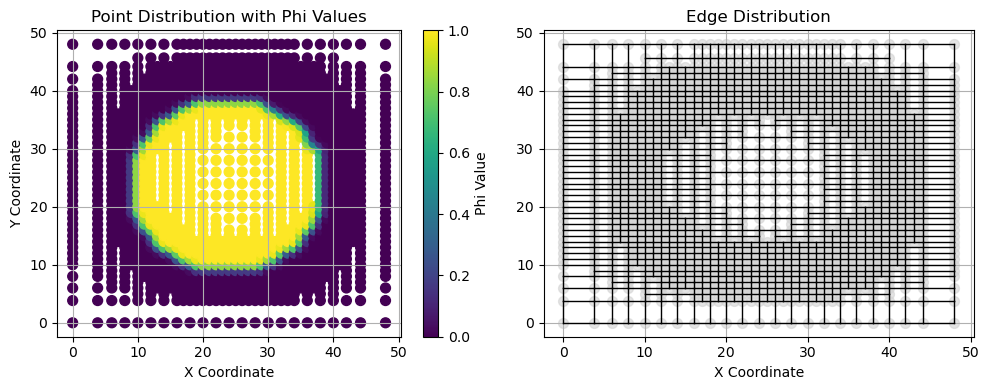

In [5]:
def plot_graph_components(points, phi, edges):
    """
    Plots nodes and edges in subplots.
    
    Args:
        points (numpy.ndarray): Nx2 array of point coordinates.
        phi (numpy.ndarray): Array of scalar values associated with each point.
        edges (numpy.ndarray): Nx2 array of index pairs representing edges.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns subplot

    # Plot points with scalar values
    scatter = axs[0].scatter(points[:, 0], points[:, 1], c=phi, cmap='viridis', s=50, marker='o')
    axs[0].set_title('Point Distribution with Phi Values')
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')
    fig.colorbar(scatter, ax=axs[0], label='Phi Value')
    axs[0].grid(True)

    # Plot edges
    axs[1].scatter(points[:, 0], points[:, 1], c='lightgray', s=50, alpha=0.6)  # plot points for reference
    for edge in edges:
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        axs[1].plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], 'k-', linewidth=1)  # 'k-' for black edges
    axs[1].set_title('Edge Distribution')
    axs[1].set_xlabel('X Coordinate')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
point_data = first_point_data
points = first_points
edge_attributes = first_edge_attributes

phi = np.round(np.array(point_data['phi']), decimals=2)  # Assuming point_data dictionary has a 'phi' key

# Extract edges from DataFrame
edges = edge_attributes[['node1', 'node2']].values

# Call the function with the necessary data
plot_graph_components(points, phi, edges)


In [6]:
def calculate_pseudo_coordinates(points, edge_index):
    """Calculate pseudo-coordinates for each edge based on node coordinates."""
    pseudo_coords = []
    for src, dest in edge_index.t():
        # Calculate the difference in x and y coordinates between connected nodes
        delta_x = points[dest, 0] - points[src, 0]
        delta_y = points[dest, 1] - points[src, 1]
        # Append the pseudo-coordinates (delta_x, delta_y)
        pseudo_coords.append([delta_x, delta_y])

    # Convert to a tensor
    pseudo_coords = torch.tensor(pseudo_coords, dtype=torch.float)
    
    # Normalize to [0, 1] as required by SplineConv
    pseudo_coords = (pseudo_coords - pseudo_coords.min(0, keepdim=True)[0]) / (
        pseudo_coords.max(0, keepdim=True)[0] - pseudo_coords.min(0, keepdim=True)[0])
    
    return pseudo_coords

def create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi):
    # Concatenate point_data into x
    point_features = np.hstack([points] + [point_data[key][:, np.newaxis] for key in point_data.keys()])
    x = torch.tensor(point_features, dtype=torch.float)  # Node features based on coordinates and scalar fields
    
    # Prepare 'phi' values from the next dataset, ensuring alignment
    next_phi_dict = {tuple(point): phi for point, phi in zip(next_points, next_phi)}
    
    # Ensure 'phi' values are only assigned to nodes that exist in both current and next dataset
    y_values = []
    for point in points:
        if tuple(point) in next_phi_dict:
            y_values.append(next_phi_dict[tuple(point)])
        else:
            y_values.append(0)  # Default value if no matching point is found

    y = torch.tensor(y_values, dtype=torch.float)

    # Use precomputed edges and calculate pseudo-coordinates as edge attributes
    edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)
    
    # Calculate the pseudo-coordinates based on node positions
    pseudo_coords = calculate_pseudo_coordinates(points, edge_index)

    # Create the graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
    return data

def create_graphs_from_datasets(vtk_data_list):
    graph_data_list = []
    total_datasets = len(vtk_data_list) - 1  # Only process up to the second-to-last dataset

    for i in range(total_datasets):
        points, point_data, elements, edge_attributes = vtk_data_list[i]
        next_points, next_point_data, _, _ = vtk_data_list[i + 1]
        next_phi = next_point_data['phi']  # 'phi' from the next dataset

        data = create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi)
        graph_data_list.append(data)

        # Calculate and print the percentage of completion
        progress_percent = ((i + 1) / total_datasets) * 100
        print(f"Processing dataset {i + 1}/{total_datasets} ({progress_percent:.2f}%) completed")

    return graph_data_list

# Example usage
# Assuming vtk_data_list is available and contains the required data
graph_data_list = create_graphs_from_datasets(vtk_data_list)

# Print details of the graph data objects
for i, data in enumerate(graph_data_list):
    print(f"Graph {i+1}:")
    print(data)
    print("-" * 60)


Processing dataset 1/27 (3.70%) completed
Processing dataset 2/27 (7.41%) completed
Processing dataset 3/27 (11.11%) completed
Processing dataset 4/27 (14.81%) completed
Processing dataset 5/27 (18.52%) completed
Processing dataset 6/27 (22.22%) completed
Processing dataset 7/27 (25.93%) completed
Processing dataset 8/27 (29.63%) completed
Processing dataset 9/27 (33.33%) completed
Processing dataset 10/27 (37.04%) completed
Processing dataset 11/27 (40.74%) completed
Processing dataset 12/27 (44.44%) completed
Processing dataset 13/27 (48.15%) completed
Processing dataset 14/27 (51.85%) completed
Processing dataset 15/27 (55.56%) completed
Processing dataset 16/27 (59.26%) completed
Processing dataset 17/27 (62.96%) completed
Processing dataset 18/27 (66.67%) completed
Processing dataset 19/27 (70.37%) completed
Processing dataset 20/27 (74.07%) completed
Processing dataset 21/27 (77.78%) completed
Processing dataset 22/27 (81.48%) completed
Processing dataset 23/27 (85.19%) completed

In [7]:
def combine_graph_data(graph_data_list):
    combined_x = []
    combined_edge_index = []
    combined_edge_attr = []
    combined_y = []
    
    node_offset = 0  # To adjust edge indices for each graph
    
    for data in graph_data_list:
        num_nodes = data.x.size(0)
        
        # Append node features
        combined_x.append(data.x)
        
        # Adjust and append edge indices
        adjusted_edge_index = data.edge_index + node_offset
        combined_edge_index.append(adjusted_edge_index)
        
        # Append edge attributes
        combined_edge_attr.append(data.edge_attr)
        
        # Append labels
        combined_y.append(data.y)
        
        # Update node offset
        node_offset += num_nodes
    
    # Concatenate all components
    combined_x = torch.cat(combined_x, dim=0)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    combined_edge_attr = torch.cat(combined_edge_attr, dim=0)
    combined_y = torch.cat(combined_y, dim=0)
    
    # Create the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=combined_y)
    
    return combined_data

# Clear existing 'data' variable if it exists
data = None

# Combine all Data objects into a single Data object
data = combine_graph_data(graph_data_list)

# Print the combined data object details
print("Combined Graph Data:")
print(data)


Combined Graph Data:
Data(x=[312889, 7], edge_index=[2, 611839], edge_attr=[611839, 2], y=[312889])


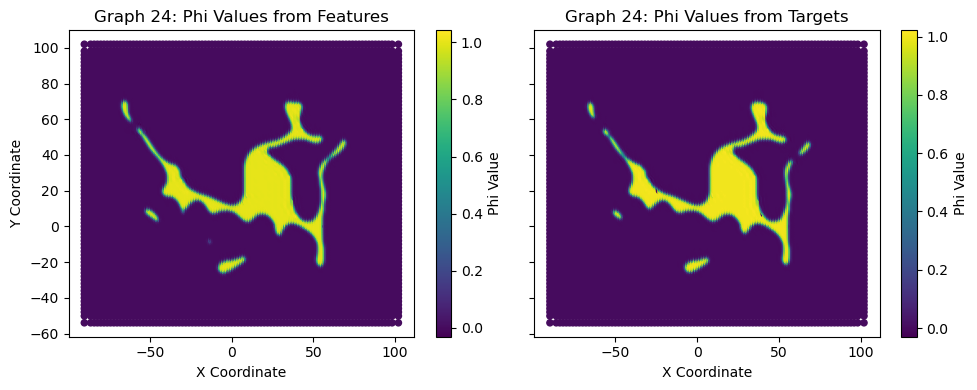

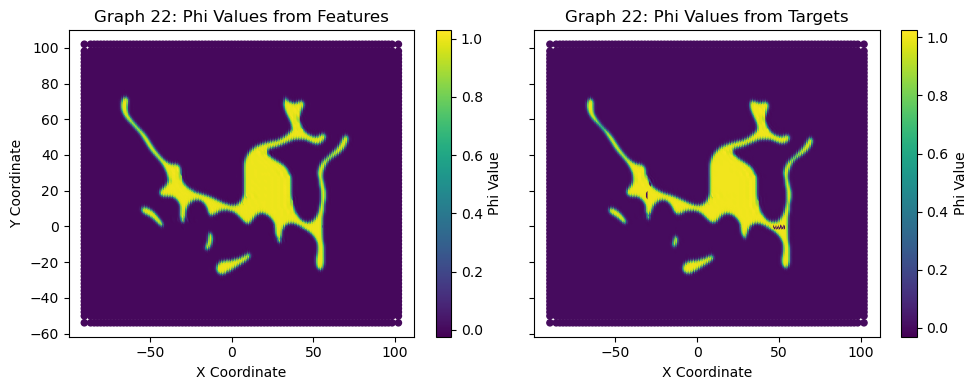

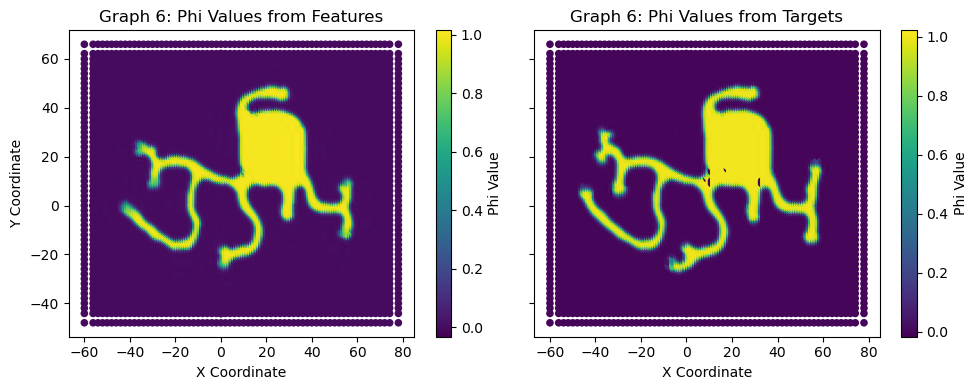

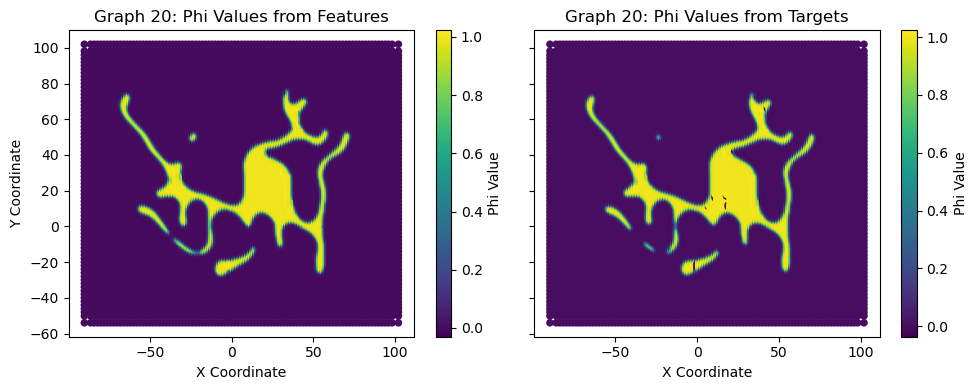

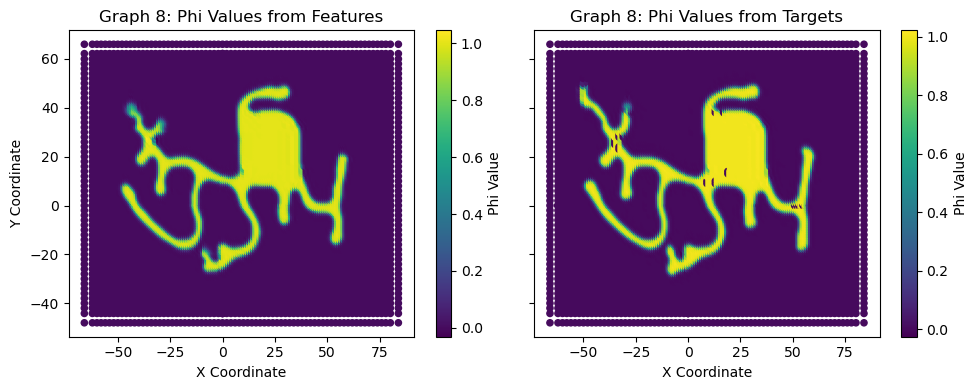

In [8]:
def visualize_graph_data(graph_data_list):
    """
    Visualizes the coordinates and two sets of 'phi' values for each randomly selected graph data object in the list.

    Args:
        graph_data_list (list): A list of Data objects from PyTorch Geometric.

    Displays:
        Scatter plots for 5 randomly selected graphs with nodes colored according to their 'phi' values from features and targets.
    """
    # Randomly select 5 graph indices if the list has more than 5 graphs
    if len(graph_data_list) > 5:
        selected_indices = random.sample(range(len(graph_data_list)), 5)
    else:
        selected_indices = range(len(graph_data_list))

    for index in selected_indices:
        data = graph_data_list[index]
        # Extract x coordinates and phi values from features (assuming phi is the last column in x)
        x_coords = data.x[:, :2].numpy()  # First two columns are coordinates
        phi_values_x = data.x[:, 2].numpy()  # Assuming the last column in x is 'phi'
        phi_values_y = data.y.numpy()  # 'phi' values used as target variable

        # Create a plot with two subplots for comparison
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

        # Plot 'phi' from features
        scatter1 = axs[0].scatter(x_coords[:, 0], x_coords[:, 1], c=phi_values_x, cmap='viridis', s=20)
        axs[0].set_title(f'Graph {index+1}: Phi Values from Features')
        axs[0].set_xlabel('X Coordinate')
        axs[0].set_ylabel('Y Coordinate')
        fig.colorbar(scatter1, ax=axs[0], label='Phi Value')

        # Plot 'phi' from targets
        scatter2 = axs[1].scatter(x_coords[:, 0], x_coords[:, 1], c=phi_values_y, cmap='viridis', s=20)
        axs[1].set_title(f'Graph {index+1}: Phi Values from Targets')
        axs[1].set_xlabel('X Coordinate')
        fig.colorbar(scatter2, ax=axs[1], label='Phi Value')

        # plt.grid(True)
        plt.tight_layout()
        plt.show()

visualize_graph_data(graph_data_list)

In [9]:
import torch
from torch_geometric.data import Data

def remove_nodes(data, threshold=1e-5):
    """
    Removes nodes based on the condition that the third channel of x is close to 0 within a threshold and y is 0.

    Args:
        data (Data): PyTorch Geometric Data object with attributes x, edge_index, y, and optionally edge_attr.
        threshold (float): Threshold value to determine closeness to zero.

    Returns:
        Data: A new PyTorch Geometric Data object with specified nodes removed.
    """
    # Condition to keep a node: Third feature in x is not close to 0 or y is not 0
    keep_nodes = (torch.abs(data.x[:, 2]) > threshold) | (torch.abs(data.y) > threshold)

    # Filter x and y based on the condition
    new_x = data.x[keep_nodes]
    new_y = data.y[keep_nodes]

    # Update edge_index to only include edges where both source and target nodes are kept
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    # Get indices of nodes that are kept
    node_indices = torch.arange(data.x.size(0), device=data.x.device)
    kept_node_indices = node_indices[keep_nodes]

    # Map old indices to new indices
    new_indices = torch.full((data.x.size(0),), -1, dtype=torch.long, device=data.x.device)
    new_indices[kept_node_indices] = torch.arange(kept_node_indices.size(0), device=data.x.device)

    # Filter edges where both nodes are kept
    mask = (new_indices[edge_index[0]] != -1) & (new_indices[edge_index[1]] != -1)
    new_edge_index = new_indices[edge_index[:, mask]]

    # Filter edge attributes if they exist
    new_edge_attr = edge_attr[mask] if edge_attr is not None else None

    # Create a new data object with the filtered data
    new_data = Data(x=new_x, edge_index=new_edge_index, y=new_y, edge_attr=new_edge_attr)
    return new_data

# Example usage:
# Assuming 'data' is your original PyTorch Geometric data object
print('Before removing all nodes close to 0')
print(data)
print('================================================')
data = remove_nodes(data, threshold=0.01)
print('After removing all nodes close to 0')
print(data)

Before removing all nodes close to 0
Data(x=[312889, 7], edge_index=[2, 611839], edge_attr=[611839, 2], y=[312889])
After removing all nodes close to 0
Data(x=[96219, 7], edge_index=[2, 174845], edge_attr=[174845, 2], y=[96219])


In [10]:
print(data.x[0:20])

tensor([[ 6.0000,  7.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3604],
        [ 6.0000,  8.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3603],
        [ 6.0000,  9.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4683],
        [ 6.0000, 10.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4532],
        [ 6.0000, 11.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2712],
        [ 6.0000, 12.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5230],
        [ 6.0000, 13.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7103],
        [ 6.0000, 36.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5079],
        [ 6.0000, 37.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5660],
        [ 6.0000, 38.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3789],
        [ 6.0000, 39.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4136],
        [ 6.0000, 40.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3544],
        [ 6.0000, 41.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3742],
        [ 6.0000, 42.0000,  0.0000,  0.0000,  0.000

In [11]:
print(data.y[0:20])

tensor([0.0140, 0.1396, 0.7567, 0.9610, 0.8831, 0.3195, 0.0308, 0.0123, 0.0147,
        0.0284, 0.0482, 0.0367, 0.0222, 0.0221, 0.0123, 0.0108, 0.0101, 0.0133,
        0.0159, 0.0435])


In [12]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.float()
# Print the final structured data object
print(data)

Data(x=[96219, 7], edge_index=[2, 174845], edge_attr=[174845, 2], y=[96219], train_mask=[96219], test_mask=[96219], val_mask=[96219], num_classes=2)


In [13]:
def normalize_features(data):
    """
    Normalizes each feature in the data.x tensor to have zero mean and unit variance.
    This function modifies the data.x attribute of the input data object in-place.

    Args:
        data (torch_geometric.data.Data): The data object containing the x attribute
            which is a tensor of shape [N, F] where N is the number of nodes and
            F is the number of features.

    Returns:
        data (torch_geometric.data.Data): The modified data object with normalized features.
    """
    # Assuming `data.x` is a PyTorch tensor of shape [N, F]
    # where N is the number of samples and F is the number of features
    means = torch.mean(data.x, dim=0)
    stds = torch.std(data.x, dim=0)
    
    # Avoid division by zero by adding a small epsilon where std is zero
    stds[stds == 0] = 1e-6
    
    # Normalize each feature
    data.x = (data.x - means) / stds
    
    return data

def add_gradient_features(data, edge_index):
    """
    Adds gradient features to the data.x tensor based on the differences in feature values along edges.
    The gradient is calculated using the pseudo-coordinates stored in edge_attr and added to the node features.

    Args:
        data (torch_geometric.data.Data): The data object containing node features and edge attributes.
        edge_index (torch.Tensor): Tensor containing the indices of source and destination nodes for each edge.

    Returns:
        data (torch_geometric.data.Data): The modified data object with additional gradient features.
    """
    num_features = data.x.shape[1] - 2  # Exclude the coordinate columns
    epsilon = 1e-6  # Small number to prevent division by zero

    for i in range(num_features):
        feature_values = data.x[:, i+2]
        gradients = torch.zeros_like(data.x[:, :2])  # Only two columns for gradient (dx, dy)

        for j, (src, dest) in enumerate(edge_index.t()):
            pseudo_coords = data.edge_attr[j]
            dx, dy = pseudo_coords[0], pseudo_coords[1]  # Assuming pseudo_coords are stored as [dx, dy]

            # Calculate gradient components separately and safely
            gradient_x = (feature_values[dest] - feature_values[src]) / (dx + epsilon)
            gradient_y = (feature_values[dest] - feature_values[src]) / (dy + epsilon)
            
            gradients[src, 0] += gradient_x
            gradients[src, 1] += gradient_y
            gradients[dest, 0] -= gradient_x
            gradients[dest, 1] -= gradient_y  # Symmetric impact

        # Concatenate gradient features to original features
        data.x = torch.cat([data.x, gradients], dim=1)

        print(f"Processed feature {i+1}/{num_features} ({(i+1) / num_features * 100:.1f}%)")

    return data

def rotate_points(data, angle_degrees):
    """
    Rotates the point coordinates in the data.x tensor by a specified angle.

    Args:
        data (torch_geometric.data.Data): The data object containing node features.
        angle_degrees (float): The angle in degrees to rotate the point coordinates.

    Returns:
        data (torch_geometric.data.Data): The modified data object with rotated coordinates.
    """
    angle = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Assume the first two columns in x are coordinates
    coords = data.x[:, :2].numpy()
    new_coords = np.dot(coords, rotation_matrix)
    data.x[:, :2] = torch.tensor(new_coords, dtype=torch.float32)

    print(f"Rotated points by {angle_degrees} degrees.")
    return data

def oversample_minority_class(data):
    """
    Duplicates samples of the minority class in the dataset to balance class distribution.

    Args:
        data (torch_geometric.data.Data): The data object containing node labels and optionally masks.

    Returns:
        data (torch_geometric.data.Data): The modified data object with duplicated minority class samples.
    """
    unique, counts = torch.unique(data.y, return_counts=True)
    minority_class = unique[torch.argmin(counts)]

    # Indices of the minority class
    minority_indices = (data.y == minority_class).nonzero(as_tuple=True)[0]
    
    # Duplicate minority class samples
    minority_x = data.x[minority_indices]
    minority_y = data.y[minority_indices]
    
    # Update the data object
    data.x = torch.cat([data.x, minority_x], dim=0)
    data.y = torch.cat([data.y, minority_y], dim=0)

    # Update masks if they exist
    if hasattr(data, 'train_mask'):
        minority_mask = data.train_mask[minority_indices]
        data.train_mask = torch.cat([data.train_mask, minority_mask], dim=0)
    if hasattr(data, 'test_mask'):
        minority_mask = data.test_mask[minority_indices]
        data.test_mask = torch.cat([data.test_mask, minority_mask], dim=0)
    if hasattr(data, 'val_mask'):
        minority_mask = data.val_mask[minority_indices]
        data.val_mask = torch.cat([data.val_mask, minority_mask], dim=0)
    
    print(f"Duplicating node {idx.item()} for minority class ({minority_class}); Progress: {len(data.y) / len(minority_indices) * 100:.1f}%")
    return data

In [14]:
# # Normalize features
# data = normalize_features(data)

# # Add gradient features
# data = add_gradient_features(data, data.edge_index)
# print('Done adding gradient features')

# # Optionally, rotate points for augmentation
# data = rotate_points(data, 45)  # Rotate by 45 degrees
# print('Done rotating points')

# # Oversample minority class to balance the dataset
# data = oversample_minority_class(data)
# print('Done oversampling minority class')

# Assuming your problem is binary classification
data.num_classes = 2  

# Print data to verify changes
print(data)

Data(x=[96219, 7], edge_index=[2, 174845], edge_attr=[174845, 2], y=[96219], train_mask=[96219], test_mask=[96219], val_mask=[96219], num_classes=2)


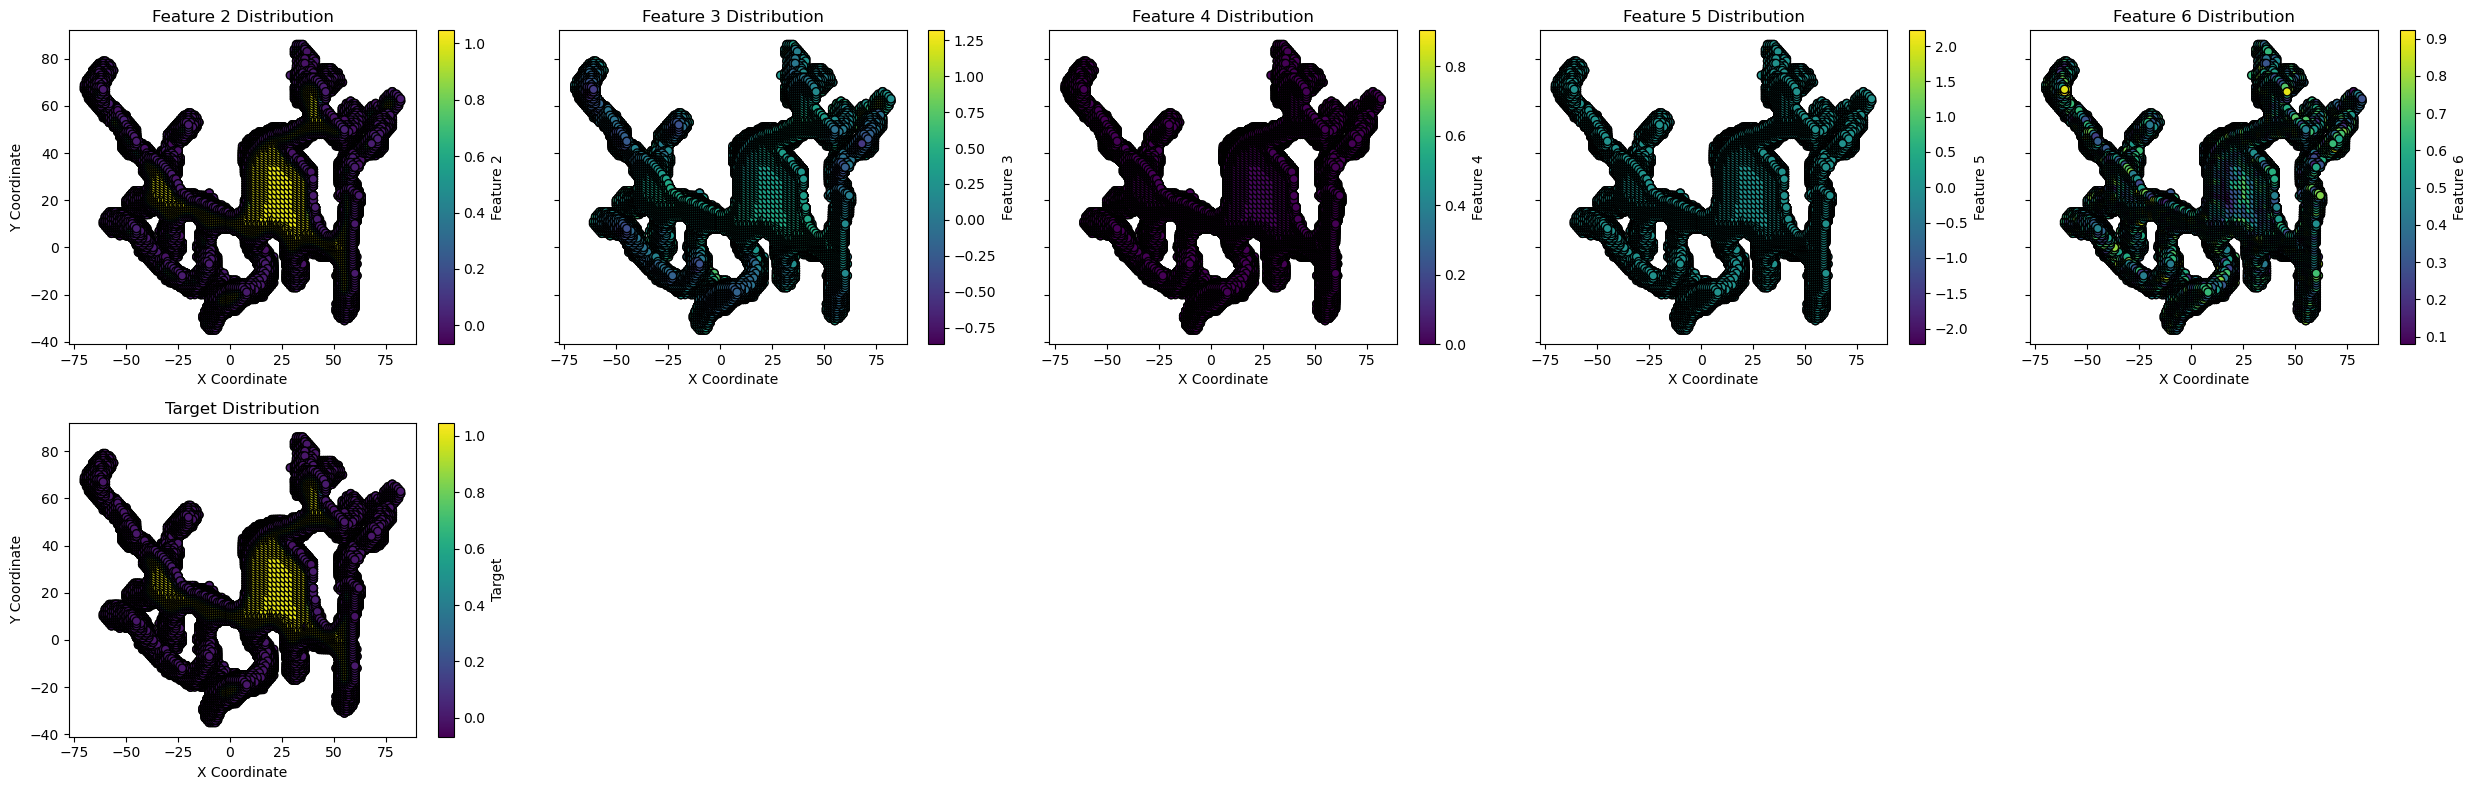

In [15]:
def plot_features_and_target(data):
    """
    Plots each feature and the target variable from the dataset based on the coordinates.

    Args:
        data (torch_geometric.data.Data): The data object containing node features, where
            the first two columns are assumed to be x and y coordinates.

    Displays:
        Scatter plots for each feature and the target variable, colored by their values.
    """
    if data.x is None or data.y is None:
        print("Node features or target values are missing in the dataset.")
        return

    # Coordinates are the first two columns
    coords = data.x[:, :2].numpy()
    num_features = data.x.size(1) - 2  # excluding the coordinate columns

    # Setup plot grid
    num_plots = num_features + 1  # Plus one for the target variable
    cols = 5  # Set number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True, squeeze=False)

    # Plot each feature
    for i in range(num_plots):
        ax = axes[i // cols, i % cols]  # Determine row and column index
        if i < num_features:
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.x[:, i+2].numpy(), cmap='viridis', s=35, edgecolor='k')
            fig.colorbar(sc, ax=ax, label=f'Feature {i+2}')
            ax.set_title(f'Feature {i+2} Distribution')
        else:
            # Plot the target variable
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.y.numpy(), cmap='viridis', s=35, edgecolor='k')
            fig.colorbar(sc, ax=ax, label='Target')
            ax.set_title('Target Distribution')

        ax.set_xlabel('X Coordinate')
        if i % cols == 0:  # Only set y-label on the first column
            ax.set_ylabel('Y Coordinate')

    # Hide empty subplots if any
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()

plot_features_and_target(data)

In [16]:
# import numpy as np

# def detect_tips_multi(phi_fine, ids, num_neuron, rows, cols):
#     length = rows * cols
#     phi_sum = np.zeros(length)  # Initialize phi_sum with zeros

#     threshold = 0.25
#     intensity_threshold = 0.1
#     offsetY = cols  # Offset for column in a 1D representation of 2D data
#     phi_threshold = 0.0

#     # Function to simulate cellBoundary condition
#     def cell_boundary(phi, threshold):
#         return 1.0 if phi > threshold else 0.0

#     # Dictionary to store max values for each ID
#     max_values = {}

#     # Iterate with precomputed values and reduced condition checks
#     for i in range(5 * cols, length - 4 * cols):
#         if cell_boundary(phi_fine[i], threshold) > 0 and round(ids[i]) != 9:
#             local_sum = 0
#             for j in range(-4, 5):
#                 for k in range(-4, 5):
#                     index = i + j * offsetY + k
#                     if 0 <= index < length:  # Ensure index is within bounds
#                         rounded_id = round(ids[index])
#                         if rounded_id == round(ids[i]) or rounded_id < 0:
#                             local_sum += cell_boundary(phi_fine[index], intensity_threshold)
            
#             phi_sum[i] = local_sum
#             phi_sum[i] = (cell_boundary(phi_fine[i], phi_threshold) / local_sum) if phi_sum[i] > 0 else 0
#             phi_sum[i] = 0 if np.isnan(phi_sum[i]) else phi_sum[i]  # Handle NaN explicitly

#             # Update max value for each ID
#             id_key = round(ids[i])
#             if id_key not in max_values or max_values[id_key] < phi_sum[i]:
#                 max_values[id_key] = phi_sum[i]

#     # Normalize phi_sum by the max value for each ID and apply thresholding
#     for i in range(length):
#         id_key = round(ids[i])
#         if id_key in max_values and max_values[id_key] != 0:
#             normalized_threshold = 0.825 * max_values[id_key]
#             phi_sum[i] = (phi_sum[i] / max_values[id_key]) if phi_sum[i] >= normalized_threshold else 0.0

#     return phi_sum

# # Example usage:
# # Assuming phi_fine, ids are numpy arrays and num_neuron, rows, cols are integers
# # phi_sum = detect_tips_multi(phi_fine, ids, num_neuron, rows, cols)


In [17]:
# Example check for NaNs in your data
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")

In [18]:
# !mkdir ./generated_data
# # Assuming 'data' is your PyTorch Geometric Data object
# torch.save(data, './generated_data/NDD.pt')

In [19]:
# # Load a single data object
# data = torch.load('./generated_data/NDD_per1000.pt')

In [20]:
def remove_nodes(data):
    # Condition to remove the node
    node_mask = ~((data.x[:, 2] == 0) & (data.y == 0))
    
    # Update node features, labels, and masks
    data.x = data.x[node_mask]
    data.y = data.y[node_mask]
    data.train_mask = data.train_mask[node_mask]
    data.test_mask = data.test_mask[node_mask]
    data.val_mask = data.val_mask[node_mask]

    # Update edge indices
    # Create a mapping from old node indices to new node indices
    node_index_mapping = torch.full((node_mask.size(0),), -1, dtype=torch.long)
    node_index_mapping[node_mask] = torch.arange(data.x.size(0))

    # Only keep edges where both nodes are still in the graph
    edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
    data.edge_index = data.edge_index[:, edge_mask]

    # Map old node indices to new node indices
    data.edge_index = node_index_mapping[data.edge_index]

    # Edge attributes (if they exist and need to be filtered accordingly)
    if data.edge_attr is not None:
        data.edge_attr = data.edge_attr[edge_mask]

    return data

data = remove_nodes(data)

In [21]:
# class Net(torch.nn.Module):
#     def __init__(self, dataset):
#         super().__init__()
#         self.conv1 = SplineConv(dataset.num_features, 64, dim=2, kernel_size=4, is_open_spline=False, degree=2, aggr="add", root_weight=True, bias=True)
#         self.conv2 = SplineConv(64, 128, dim=2, kernel_size=4, is_open_spline=False, degree=2, aggr="add", root_weight=True, bias=True)
#         self.conv3 = SplineConv(128, 1, dim=2, kernel_size=4, is_open_spline=False, degree=2, aggr="add", root_weight=True, bias=True)

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         x = F.dropout(x, training=self.training, p=0.1)
#         x = F.elu(self.conv1(x, edge_index, edge_attr))
#         x = F.dropout(x, training=self.training, p=0.1)
#         x = F.elu(self.conv2(x, edge_index, edge_attr))
#         x = F.dropout(x, training=self.training, p=0.1)
#         x = self.conv3(x, edge_index, edge_attr)
#         return torch.sigmoid(x)  # Use sigmoid to output a value between 0 and 1

# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask].unsqueeze(1))
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

# @torch.no_grad()
# def test():
#     model.eval()
#     out = model(data)  # Output shape: [num_nodes, 1]
#     out = out.squeeze()  # Squeeze to match target shape [num_nodes]
    
#     # Calculate accuracy instead of mean absolute error
#     predictions = (out > 0.5).float()  # Convert probabilities to binary predictions
#     train_accuracy = (predictions[data.train_mask] == data.y[data.train_mask]).float().mean().item()
#     test_accuracy = (predictions[data.test_mask] == data.y[data.test_mask]).float().mean().item()
    
#     return train_accuracy, test_accuracy

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SplineConv(dataset.num_features, 64, dim=2, kernel_size=4, is_open_spline=False, degree=2, aggr="add", root_weight=True, bias=True)
        self.conv2 = SplineConv(64, 128, dim=2, kernel_size=4, is_open_spline=False, degree=2, aggr="add", root_weight=True, bias=True)
        self.conv3 = SplineConv(128, 1, dim=2, kernel_size=4, is_open_spline=False, degree=2, aggr="add", root_weight=True, bias=True)  # Output a single value

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index, edge_attr)
        return torch.sigmoid(x)  # Use sigmoid to output a value between 0 and 1

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].unsqueeze(1))  # Use MSE loss for continuous output
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

@torch.no_grad()
def test():
    model.eval()
    out = model(data)  # Output shape: [num_nodes, 1]
    out = out.squeeze()  # Squeeze to match target shape [num_nodes]

    # Calculate training error (mean absolute error for interpretability)
    train_error = F.l1_loss(out[data.train_mask], data.y[data.train_mask]).item()

    # Calculate test error (mean absolute error for interpretability)
    test_error = F.l1_loss(out[data.test_mask], data.y[data.test_mask]).item()
    
    return train_error, test_error

# GPU Memory Monitoring Function
def print_gpu_memory(device):
    torch.cuda.synchronize(device)
    allocated = torch.cuda.memory_allocated(device)
    reserved = torch.cuda.memory_reserved(device)
    print(f"Allocated memory: {allocated / (1024**3):.3f} GB")
    print(f"Reserved memory: {reserved / (1024**3):.3f} GB")

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the Net model
model = Net(data)  # Instantiate the model with the data

# # Initialize weights
# def weights_init(m):
#     if isinstance(m, torch.nn.Linear) or isinstance(m, SplineConv):
#         torch.nn.init.xavier_uniform_(m.weight.data)

# # Apply the weights initialization
# model.apply(weights_init)

# Move to the appropriate device
model = model.to(device)
data = data.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 101):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')
    if epoch % 20 == 0:
        print_gpu_memory(torch.device('cuda:0'))

Epoch: 001, Train: 0.3939, Test: 0.3961
Epoch: 002, Train: 0.3849, Test: 0.3867
Epoch: 003, Train: 0.3682, Test: 0.3684
Epoch: 004, Train: 0.3534, Test: 0.3517
Epoch: 005, Train: 0.3660, Test: 0.3644
Epoch: 006, Train: 0.3573, Test: 0.3556
Epoch: 007, Train: 0.3379, Test: 0.3363
Epoch: 008, Train: 0.3374, Test: 0.3360
Epoch: 009, Train: 0.3355, Test: 0.3343
Epoch: 010, Train: 0.3276, Test: 0.3260
Epoch: 011, Train: 0.3259, Test: 0.3235
Epoch: 012, Train: 0.3281, Test: 0.3256
Epoch: 013, Train: 0.3225, Test: 0.3201
Epoch: 014, Train: 0.3153, Test: 0.3132
Epoch: 015, Train: 0.3157, Test: 0.3144
Epoch: 016, Train: 0.3165, Test: 0.3155
Epoch: 017, Train: 0.3126, Test: 0.3112
Epoch: 018, Train: 0.3090, Test: 0.3070
Epoch: 019, Train: 0.3086, Test: 0.3063
Epoch: 020, Train: 0.3067, Test: 0.3045
Allocated memory: 0.025 GB
Reserved memory: 0.520 GB
Epoch: 021, Train: 0.3040, Test: 0.3021
Epoch: 022, Train: 0.3037, Test: 0.3022
Epoch: 023, Train: 0.3028, Test: 0.3015
Epoch: 024, Train: 0.2996, 

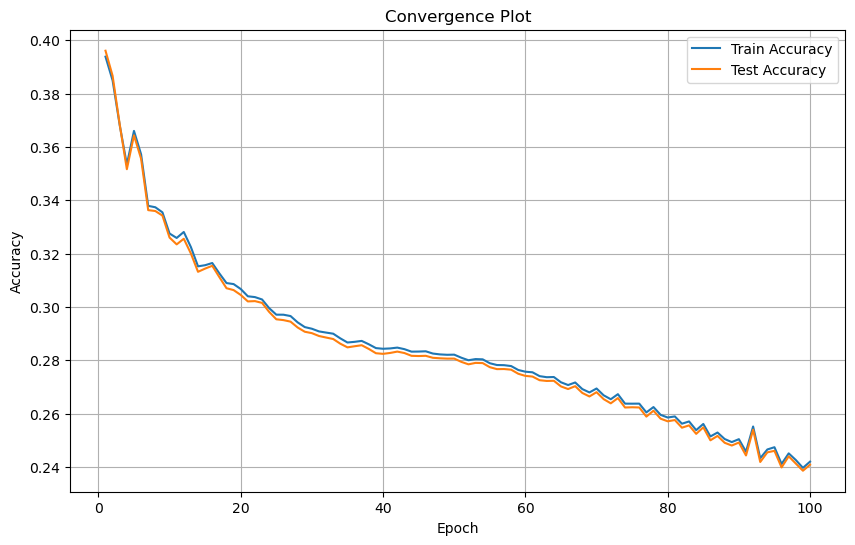

In [23]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_acc_list, label='Train Accuracy')
plt.plot(range(1, 101), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
@torch.no_grad()
def evaluate_model(data, model):
    model.eval()  # Set the model to evaluation mode
    out = model(data)  # Get the output of the model (log probabilities)
    
    # Get the predicted classes and actual classes for the test set
    pred = out[data.test_mask].max(1)[1]  # Get the index of the max log-probability
    actual = data.y[data.test_mask]  # Actual labels
    
    # Calculate accuracy
    correct = pred.eq(actual).sum().item()  # Count of correct predictions
    total = data.test_mask.sum().item()  # Total number of test samples
    accuracy = correct / total  # Accuracy as a ratio
    
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Print a few sample predictions versus actual values
    print("\nSample Predictions:")
    num_samples = min(100, len(pred))  # Show up to 10 samples
    for i in range(num_samples):
        print(f'Predicted: {pred[i].item()}, Actual: {actual[i].item()}')

# Call the evaluation function after training is complete
evaluate_model(data, model)

Test Accuracy: 0.0078

Sample Predictions:
Predicted: 0, Actual: 0.01232369989156723
Predicted: 0, Actual: 0.028424400836229324
Predicted: 0, Actual: 0.04816190153360367
Predicted: 0, Actual: 0.03665180131793022
Predicted: 0, Actual: 0.010067899711430073
Predicted: 0, Actual: 0.9323269724845886
Predicted: 0, Actual: 0.06650280207395554
Predicted: 0, Actual: 0.07619470357894897
Predicted: 0, Actual: 0.02143310010433197
Predicted: 0, Actual: 0.05476079881191254
Predicted: 0, Actual: 0.07883434742689133
Predicted: 0, Actual: 0.21757599711418152
Predicted: 0, Actual: 0.725271999835968
Predicted: 0, Actual: 0.7219460010528564
Predicted: 0, Actual: 0.3115540146827698
Predicted: 0, Actual: 0.3820599913597107
Predicted: 0, Actual: 0.8218410015106201
Predicted: 0, Actual: 0.9387590289115906
Predicted: 0, Actual: 0.36772701144218445
Predicted: 0, Actual: 0.3340649902820587
Predicted: 0, Actual: 0.8959199786186218
Predicted: 0, Actual: 0.9660639762878418
Predicted: 0, Actual: 0.9630560278892517
P

Test Accuracy: 0.0078


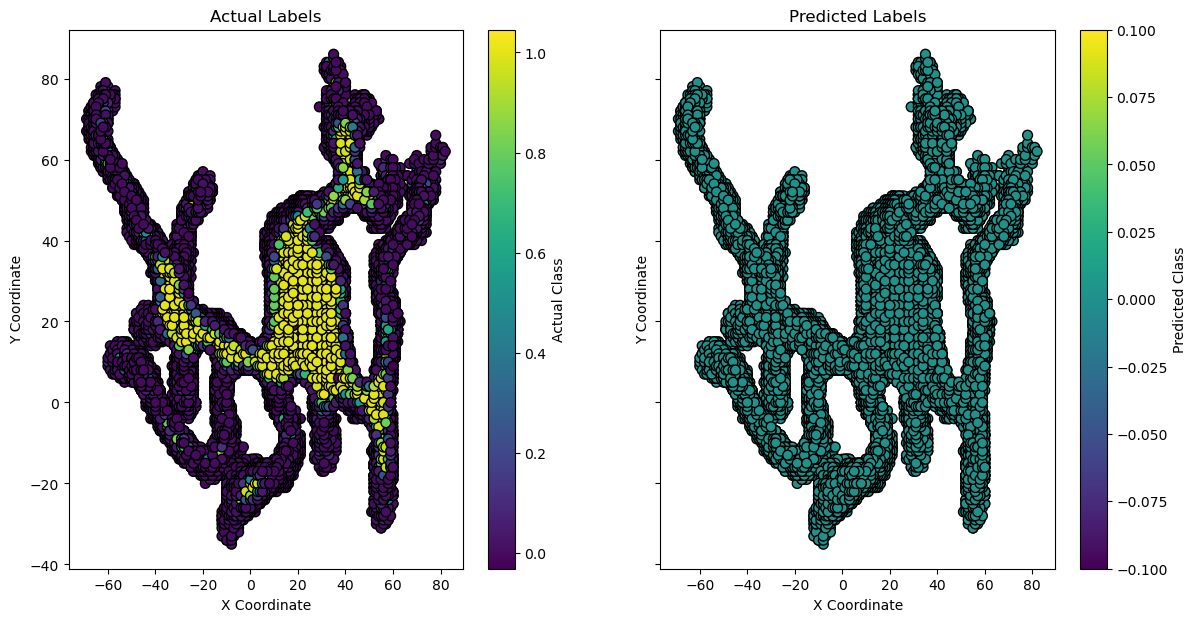

In [25]:
@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45):  # Assuming a rotation was applied initially
    model.eval()  # Set the model to evaluation mode
    out = model(data)  # Get the output of the model (log probabilities)
    
    # Get the predicted classes and actual classes for the test set
    pred = out[data.test_mask].max(1)[1]  # Get the index of the max log-probability
    actual = data.y[data.test_mask]  # Actual labels
    
    # Calculate accuracy
    correct = pred.eq(actual).sum().item()  # Count of correct predictions
    total = data.test_mask.sum().item()  # Total number of test samples
    accuracy = correct / total  # Accuracy as a ratio
    
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Reverse rotation for visualization
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])
    coords = data.x[data.test_mask][:, :2].cpu().numpy()  # Assuming the first two columns in x are coordinates
    new_coords = np.dot(coords, rotation_matrix)  # Reverse the rotation applied earlier

    # Visualization of 2D predictions
    actual_colors = actual.cpu().numpy()
    predicted_colors = pred.cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=actual_colors, cmap='viridis', edgecolor='k', s=50)
    ax[0].set_title('Actual Labels')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Actual Class')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=predicted_colors, cmap='viridis', edgecolor='k', s=50)
    ax[1].set_title('Predicted Labels')
    ax[1].set_xlabel('X Coordinate')
    ax[1].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Predicted Class')

    plt.show()

# Call the evaluation function after training is complete
evaluate_model(data, model, 0)